# Final Project - ADHD
- Aiden Hai (xhai2)
- Zexi Tracy Chen (zexic7)
- Dataset（from  Healthy Brain Network ）：https://www.kaggle.com/competitions/widsdatathon2025/overview

Research Questions:
- Primary research question:
Does using distance-based representations improve prediction performance compared to directly using high-dimensional connectivity features?
- Secondary research question 1:
After MDS embedding, which classification model performs better: Logistic Regression or Random Forest, and how does hyperparameter tuning with GridSearchCV affect their performance?
- Secondary research question 2:
How does the choice of distance matrix influence model accuracy and overall performance?


import all the models


In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

Import and check the dataset：

In [2]:
fc_path = "/Users/tracy/Desktop/wids/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"        
label_path = "/Users/tracy/Desktop/wids/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx"  
fc_df = pd.read_csv(fc_path)
label_df = pd.read_excel(label_path, sheet_name="training_combined")
label_df = label_df[["participant_id", "ADHD_Outcome"]]

In [3]:
#merge the files
df = fc_df.merge(label_df, on="participant_id", how="inner")

print("Merged sample size:", len(df))
print(df.head())

# Split into ADHD and non-ADHD groups
adhd_df = df[df["ADHD_Outcome"] == 1]
non_df  = df[df["ADHD_Outcome"] == 0]

print("Total ADHD:", len(adhd_df))
print("Total non-ADHD:", len(non_df))

Merged sample size: 1213
  participant_id  0throw_1thcolumn  0throw_2thcolumn  0throw_3thcolumn  \
0   70z8Q2xdTXM3          0.222930          0.527903          0.429966   
1   WHWymJu6zNZi          0.614765          0.577255          0.496127   
2   4PAQp1M6EyAo         -0.116833          0.458408          0.260703   
3   obEacy4Of68I          0.199688          0.752714          0.658283   
4   s7WzzDcmDOhF          0.227321          0.613268          0.621447   

   0throw_4thcolumn  0throw_5thcolumn  0throw_6thcolumn  0throw_7thcolumn  \
0          0.060457          0.566489          0.315342          0.508408   
1          0.496606          0.404686          0.439724          0.122590   
2          0.639031          0.769337          0.442528          0.637110   
3          0.575096          0.692867          0.645789          0.522750   
4          0.562673          0.736709          0.589813          0.266676   

   0throw_8thcolumn  0throw_9thcolumn  ...  195throw_197thcolumn  \

Files preprocessing:
- Since we have 831 ADHD subjects and 382 non-ADHD subjects, which is imbalanced, we randomly choose 300 ADHD and 300 non-ADHD from the dataset and form a new file.

In [4]:
RANDOM_SEED = 42
N_PER_GROUP = 300

adhd_sample = adhd_df.sample(n=N_PER_GROUP, random_state=RANDOM_SEED)
non_sample  = non_df.sample(n=N_PER_GROUP,  random_state=RANDOM_SEED)

# Concatenate ADHD first, non-ADHD second
sub_df = pd.concat([adhd_sample, non_sample], axis=0).reset_index(drop=True)

# Save subject order for reference
order_info = sub_df[["participant_id", "ADHD_Outcome"]].copy()
order_info["Group"] = order_info["ADHD_Outcome"].map({1: "ADHD", 0: "Non-ADHD"})
order_info.to_csv("subject_order_600.csv", index=False)

print("Saved to subject_order_600.csv")

Saved to subject_order_600.csv


Check the logistic regression and random forest performance on 19900 functional connectivity matrix of these 600 subjects (300ADHD & 300Non-ADHD)

In [5]:
sub_ids = order_info["participant_id"].unique().tolist()
fc_600    = fc_df[fc_df["participant_id"].isin(sub_ids)].copy()
label_600 = label_df[label_df["participant_id"].isin(sub_ids)].copy()

# FC + label
df_600 = fc_600.merge(label_600, on="participant_id", how="inner")
print("Merged subset size:", len(df_600))

df_600 = df_600.set_index("participant_id").loc[sub_ids].reset_index()


drop_cols = ["participant_id", "ADHD_Outcome"]

if "Sex_F" in df_600.columns:
    drop_cols.append("Sex_F")

feature_cols = [c for c in df_600.columns if c not in drop_cols]

X = df_600[feature_cols].values          # (100, n_features)
y = df_600["ADHD_Outcome"].values       # (100,)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("ADHD count:", (y == 1).sum(), "Non-ADHD count:", (y == 0).sum())

kf = KFold(n_splits=5, shuffle=True, random_state=42)

Merged subset size: 600
X shape: (600, 19900)
y shape: (600,)
ADHD count: 300 Non-ADHD count: 300


Logistic Regression

In [6]:
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=1000
    ))
])

logreg_scores = cross_val_score(
    log_reg_pipeline,
    X,
    y,
    cv=kf,
    scoring="accuracy"
)

print("\nLogistic Regression on 100-subject subset (5-fold CV)")
print("Acc per fold:", np.round(logreg_scores, 3))
print("Mean acc:", np.mean(logreg_scores), "Std:", np.std(logreg_scores))


Logistic Regression on 100-subject subset (5-fold CV)
Acc per fold: [0.592 0.533 0.55  0.517 0.583]
Mean acc: 0.555 Std: 0.02867441755680875


Random Forest

In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_scores = cross_val_score(
    rf_clf,
    X,
    y,
    cv=kf,
    scoring="accuracy"
)

print("\nRandom Forest on 100-subject subset (5-fold CV)")
print("Acc per fold:", np.round(rf_scores, 3))
print("Mean acc:", np.mean(rf_scores), "Std:", np.std(rf_scores))


Random Forest on 100-subject subset (5-fold CV)
Acc per fold: [0.558 0.483 0.542 0.458 0.575]
Mean acc: 0.5233333333333334 Std: 0.04484541349024569


Then，we calculate the distance matrix

1. correlation distance (1 - Pearson correlation)
- Correlation distance is computed by first assessing the similarity of two vectors’ variation patterns using a correlation coefficient, which reflects how consistently their features deviate from their respective means. This similarity measure is then converted into a distance by subtracting it from one, so that more similar patterns correspond to smaller distances.

In [8]:
# Extract FC feature matrix X

drop_cols = ["participant_id", "ADHD_Outcome"]  
feature_cols = [c for c in sub_df.columns if c not in drop_cols]

X = sub_df[feature_cols].to_numpy()
print("X shape:", X.shape)   # Expect (100, number_of_features)

X shape: (600, 19900)


In [9]:
metric = "correlation"      

corr_dist_mat = squareform(pdist(X, metric=metric))
print("Distance matrix shape:", corr_dist_mat.shape)

corr_dist_df = pd.DataFrame(
    corr_dist_mat,
    index=order_info["participant_id"],
    columns=order_info["participant_id"]
)
corr_dist_df.to_csv(f"dist_matrix_100_{metric}.csv")

print(f"Distance matrix saved to dist_matrix_100_{metric}.csv")

Distance matrix shape: (600, 600)
Distance matrix saved to dist_matrix_100_correlation.csv


Plot the heatmap of the correlation distance we just calculate to see if there's any clear patterns to get the difference of ADHD subjects and non-ADHD subjects

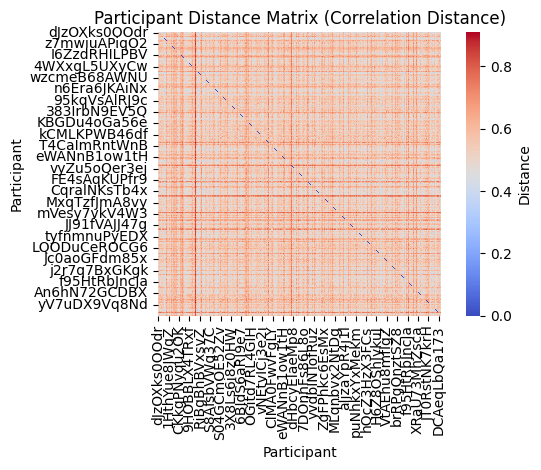

In [56]:
sns.heatmap(
    corr_dist_df,
    cmap="coolwarm",        
    square=True,
    cbar_kws={"label": "Distance"}
)
plt.title("Participant Distance Matrix (Correlation Distance)")
plt.xlabel("Participant")
plt.ylabel("Participant")
plt.tight_layout()
plt.show()

Observation: Surprisingly, there's no clear different patterns of the distance of ADHD-ADHD, nonAHDH-AHDH, ADHD-nonADHD, nonADHD-nonADHD. We're guessing this may be caused by 19900 features from the dataset which is too noisy.

Then, we did the gridsearchCV on components of mds, c from logistic regression, and numbers of the estimators & max depth of random forest to see under what parameters, the models work the best.

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

N_COMPONENTS_GRID = [2, 3, 4, 5, 6, 7, 8, 9, 10]
C_GRID = [0.01, 0.1, 1, 5, 10, 50, 100]
RF_GRID = {
    "n_estimators": [100, 200, 300, 500,1000],
    "max_depth": [None, 1, 2, 3, 5, 10, 20]
}

best_lr = {"score": -np.inf}
best_rf = {"score": -np.inf}

In [60]:
results = []

order_info_sorted = order_info.sort_values("ADHD_Outcome")  
pid_order = order_info_sorted["participant_id"].tolist()
dist_df = corr_dist_df.loc[pid_order, pid_order]
D = dist_df.values 

for N_COMPONENTS in N_COMPONENTS_GRID:
    mds = MDS(
        n_components=N_COMPONENTS,
        dissimilarity="precomputed",
        random_state=42,
        n_init=4,
        max_iter=300
    )
    X_embed = mds.fit_transform(D)
    X = StandardScaler().fit_transform(X_embed)

    gs_lr = GridSearchCV(
        LogisticRegression(penalty="l2", solver="lbfgs", max_iter=1000),
        param_grid={"C": C_GRID},
        scoring="accuracy",
        cv=kf,
        n_jobs=-1,
        refit=True
    )
    gs_lr.fit(X, y)

    gs_rf = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=RF_GRID,
        scoring="accuracy",
        cv=kf,
        n_jobs=-1,
        refit=True
    )
    gs_rf.fit(X, y)

    results.append({
        "N_COMPONENTS": N_COMPONENTS,
        "LR_best_score": gs_lr.best_score_,
        "LR_best_C": gs_lr.best_params_["C"],
        "RF_best_score": gs_rf.best_score_,
        "RF_best_depth": gs_rf.best_params_["max_depth"],
        "RF_best_trees": gs_rf.best_params_["n_estimators"],
    })

    if gs_lr.best_score_ > best_lr["score"]:
        best_lr = {"score": gs_lr.best_score_, "N_COMPONENTS": N_COMPONENTS, "params": gs_lr.best_params_}
    if gs_rf.best_score_ > best_rf["score"]:
        best_rf = {"score": gs_rf.best_score_, "N_COMPONENTS": N_COMPONENTS, "params": gs_rf.best_params_}

    print(f"\nN_COMPONENTS={N_COMPONENTS}")
    print("  LR best:", gs_lr.best_score_, gs_lr.best_params_)
    print("  RF best:", gs_rf.best_score_, gs_rf.best_params_)

print("\nBEST OVERALL")
print("Best LR :", best_lr)
print("Best RF :", best_rf)




N_COMPONENTS=2
  LR best: 0.45999999999999996 {'C': 1}
  RF best: 0.5216666666666667 {'max_depth': 1, 'n_estimators': 500}

N_COMPONENTS=3
  LR best: 0.5333333333333333 {'C': 0.01}
  RF best: 0.5566666666666666 {'max_depth': 3, 'n_estimators': 100}

N_COMPONENTS=4
  LR best: 0.5033333333333333 {'C': 0.01}
  RF best: 0.5149999999999999 {'max_depth': 1, 'n_estimators': 300}

N_COMPONENTS=5
  LR best: 0.5033333333333333 {'C': 0.1}
  RF best: 0.5333333333333333 {'max_depth': 5, 'n_estimators': 300}

N_COMPONENTS=6
  LR best: 0.4966666666666667 {'C': 1}
  RF best: 0.52 {'max_depth': None, 'n_estimators': 200}

N_COMPONENTS=7
  LR best: 0.5149999999999999 {'C': 1}
  RF best: 0.5533333333333333 {'max_depth': 5, 'n_estimators': 200}

N_COMPONENTS=8
  LR best: 0.5383333333333333 {'C': 1}
  RF best: 0.5316666666666666 {'max_depth': 10, 'n_estimators': 100}

N_COMPONENTS=9
  LR best: 0.5133333333333333 {'C': 0.1}
  RF best: 0.5383333333333333 {'max_depth': 5, 'n_estimators': 500}

N_COMPONENTS=1

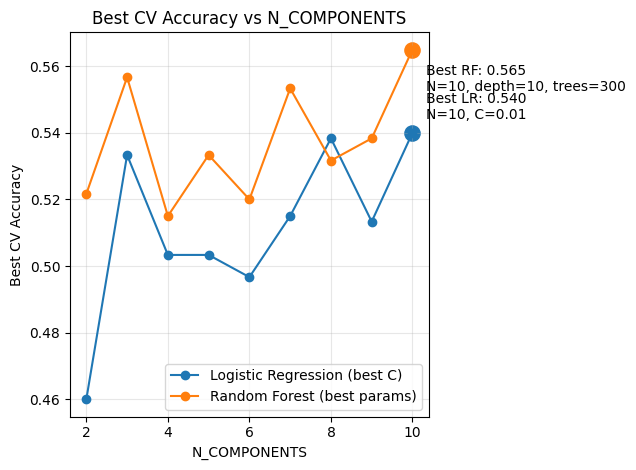

In [61]:
res_df = pd.DataFrame(results).sort_values("N_COMPONENTS")

plt.plot(res_df["N_COMPONENTS"], res_df["LR_best_score"], marker="o", label="Logistic Regression (best C)")
plt.plot(res_df["N_COMPONENTS"], res_df["RF_best_score"], marker="o", label="Random Forest (best params)")

plt.scatter([best_lr["N_COMPONENTS"]], [best_lr["score"]], s=120)
plt.scatter([best_rf["N_COMPONENTS"]], [best_rf["score"]], s=120)

plt.annotate(f"Best LR: {best_lr['score']:.3f}\nN={best_lr['N_COMPONENTS']}, C={best_lr['params']['C']}",
             (best_lr["N_COMPONENTS"], best_lr["score"]), textcoords="offset points", xytext=(10, 10))
plt.annotate(f"Best RF: {best_rf['score']:.3f}\nN={best_rf['N_COMPONENTS']}, depth={best_rf['params']['max_depth']}, trees={best_rf['params']['n_estimators']}",
             (best_rf["N_COMPONENTS"], best_rf["score"]), textcoords="offset points", xytext=(10, -30))

plt.xlabel("N_COMPONENTS")
plt.ylabel("Best CV Accuracy")
plt.title("Best CV Accuracy vs N_COMPONENTS")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

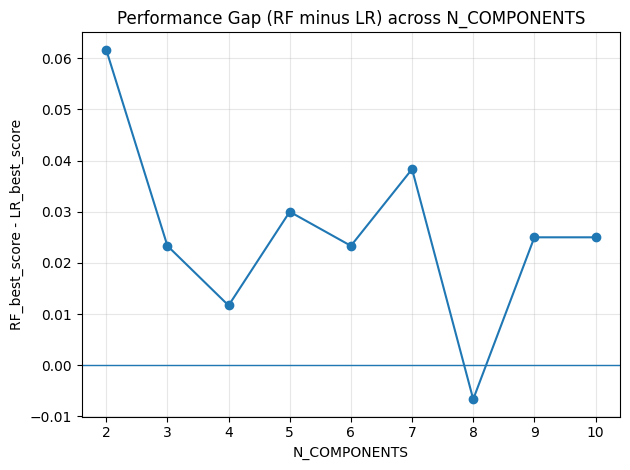

In [15]:
#RF-LR
plt.plot(res_df["N_COMPONENTS"], res_df["RF_best_score"] - res_df["LR_best_score"], marker="o")
plt.axhline(0, linewidth=1)
plt.xlabel("N_COMPONENTS")
plt.ylabel("RF_best_score - LR_best_score")
plt.title("Performance Gap (RF minus LR) across N_COMPONENTS")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

We also plot the first two dimention of mds embedding with the best parameters obtained from previous codes.

In [16]:
def plot_mds_2d(D, y, N_COMPONENTS, title):
    mds = MDS(
        n_components=2,          
        dissimilarity="precomputed",
        random_state=42,
        n_init=4,
        max_iter=300
    )
    X_2d = mds.fit_transform(D)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=y,
        cmap="coolwarm",
        alpha=0.8
    )
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.title(title)
    plt.colorbar(scatter, label="Class label")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

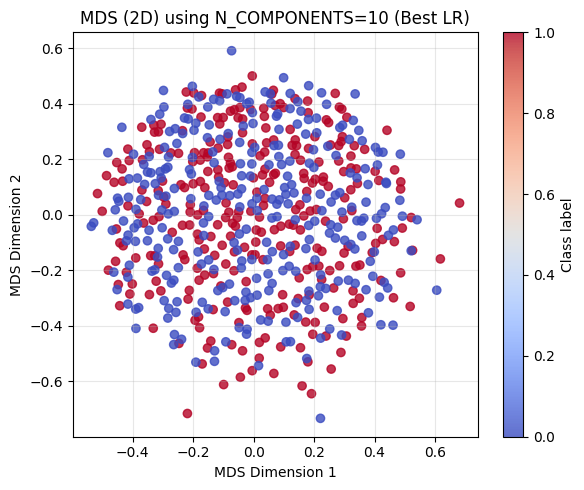

In [18]:
best_N_lr = best_lr["N_COMPONENTS"]
best_N_rf = best_rf["N_COMPONENTS"]

plot_mds_2d(
    D,
    y,
    best_N_lr,
    title=f"MDS (2D) using N_COMPONENTS={best_N_lr} (Best LR)"
)


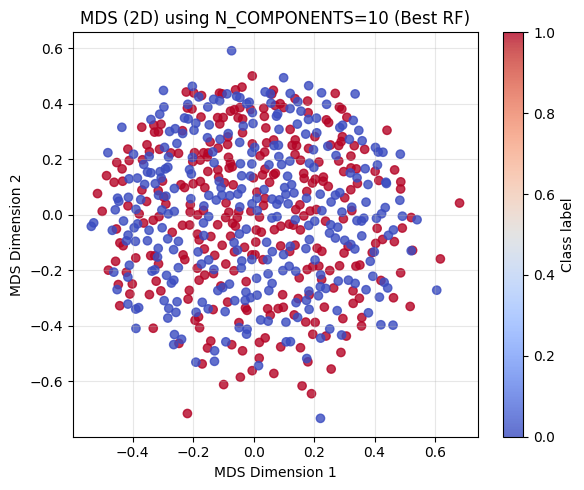

In [19]:
plot_mds_2d(
    D,
    y,
    best_N_rf,
    title=f"MDS (2D) using N_COMPONENTS={best_N_rf} (Best RF)"
)


2. Euclidean distance
- Euclidean distance measures the straight-line distance between two data points in the feature space. Smaller distances indicate more similar feature patterns between participants, while larger distances indicate greater differences. The distance matrix summarizes pairwise dissimilarities and is used as input for subsequent analyses.

calculate the euclidean distance and output the file

In [20]:
metric = "euclidean"      

euc_dist_mat = squareform(pdist(X, metric=metric))
print("Distance matrix shape:", euc_dist_mat.shape)

euc_dist_df = pd.DataFrame(
    euc_dist_mat,
    index=order_info["participant_id"],
    columns=order_info["participant_id"]
)
euc_dist_df.to_csv(f"dist_matrix_100_{metric}.csv")

print(f"Distance matrix saved to dist_matrix_100_{metric}.csv")

Distance matrix shape: (600, 600)
Distance matrix saved to dist_matrix_100_euclidean.csv


Plot the heatmap of the correlation distance we just calculate to see if there's any clear patterns to get the difference of ADHD subjects and non-ADHD subjects

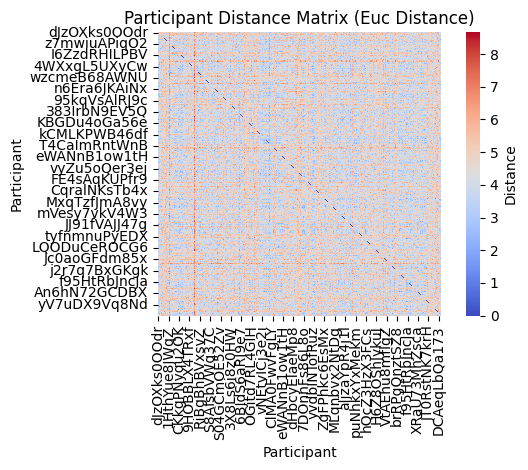

In [63]:
sns.heatmap(
    euc_dist_df,
    cmap="coolwarm",        
    square=True,
    cbar_kws={"label": "Distance"}
)
plt.title("Participant Distance Matrix (Euc Distance)")
plt.xlabel("Participant")
plt.ylabel("Participant")
plt.tight_layout()
plt.show()

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

N_COMPONENTS_GRID = [2, 3, 4, 5, 6, 7, 8, 9, 10]
C_GRID = [0.01, 0.1, 1, 5, 10, 50, 100]
RF_GRID = {
    "n_estimators": [100, 200, 300, 500,1000],
    "max_depth": [None, 1, 2, 3, 5, 10, 20]
}

best_lr = {"score": -np.inf}
best_rf = {"score": -np.inf}

In [23]:
results = []

order_info_sorted = order_info.sort_values("ADHD_Outcome")  
pid_order = order_info_sorted["participant_id"].tolist()
dist_df = euc_dist_df.loc[pid_order, pid_order]
D = dist_df.values 

for N_COMPONENTS in N_COMPONENTS_GRID:
    mds = MDS(
        n_components=N_COMPONENTS,
        dissimilarity="precomputed",
        random_state=42,
        n_init=4,
        max_iter=300
    )
    X_embed = mds.fit_transform(D)
    X = StandardScaler().fit_transform(X_embed)

    gs_lr = GridSearchCV(
        LogisticRegression(penalty="l2", solver="lbfgs", max_iter=1000),
        param_grid={"C": C_GRID},
        scoring="accuracy",
        cv=kf,
        n_jobs=-1,
        refit=True
    )
    gs_lr.fit(X, y)

    gs_rf = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=RF_GRID,
        scoring="accuracy",
        cv=kf,
        n_jobs=-1,
        refit=True
    )
    gs_rf.fit(X, y)

    results.append({
        "N_COMPONENTS": N_COMPONENTS,
        "LR_best_score": gs_lr.best_score_,
        "LR_best_C": gs_lr.best_params_["C"],
        "RF_best_score": gs_rf.best_score_,
        "RF_best_depth": gs_rf.best_params_["max_depth"],
        "RF_best_trees": gs_rf.best_params_["n_estimators"],
    })

    if gs_lr.best_score_ > best_lr["score"]:
        best_lr = {"score": gs_lr.best_score_, "N_COMPONENTS": N_COMPONENTS, "params": gs_lr.best_params_}
    if gs_rf.best_score_ > best_rf["score"]:
        best_rf = {"score": gs_rf.best_score_, "N_COMPONENTS": N_COMPONENTS, "params": gs_rf.best_params_}

    print(f"\nN_COMPONENTS={N_COMPONENTS}")
    print("  LR best:", gs_lr.best_score_, gs_lr.best_params_)
    print("  RF best:", gs_rf.best_score_, gs_rf.best_params_)

print("\nBEST OVERALL")
print("Best LR :", best_lr)
print("Best RF :", best_rf)



N_COMPONENTS=2
  LR best: 0.53 {'C': 5}
  RF best: 0.5516666666666665 {'max_depth': None, 'n_estimators': 500}

N_COMPONENTS=3
  LR best: 0.5166666666666667 {'C': 1}
  RF best: 0.5316666666666666 {'max_depth': 20, 'n_estimators': 100}

N_COMPONENTS=4
  LR best: 0.5383333333333333 {'C': 0.01}
  RF best: 0.5216666666666667 {'max_depth': 1, 'n_estimators': 300}

N_COMPONENTS=5
  LR best: 0.5233333333333333 {'C': 0.1}
  RF best: 0.5416666666666667 {'max_depth': 3, 'n_estimators': 100}

N_COMPONENTS=6
  LR best: 0.5166666666666667 {'C': 0.1}
  RF best: 0.55 {'max_depth': 5, 'n_estimators': 200}

N_COMPONENTS=7
  LR best: 0.5283333333333333 {'C': 0.1}
  RF best: 0.5433333333333333 {'max_depth': 5, 'n_estimators': 200}

N_COMPONENTS=8
  LR best: 0.5266666666666666 {'C': 0.1}
  RF best: 0.5366666666666667 {'max_depth': 20, 'n_estimators': 200}

N_COMPONENTS=9
  LR best: 0.505 {'C': 0.1}
  RF best: 0.5233333333333333 {'max_depth': 5, 'n_estimators': 1000}

N_COMPONENTS=10
  LR best: 0.52666666

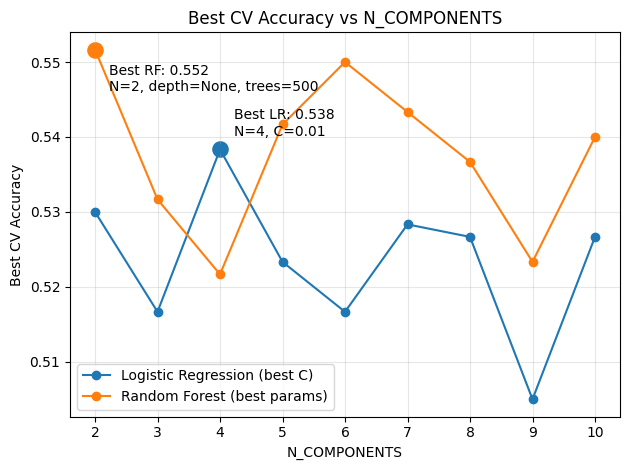

In [24]:
res_df = pd.DataFrame(results).sort_values("N_COMPONENTS")

plt.plot(res_df["N_COMPONENTS"], res_df["LR_best_score"], marker="o", label="Logistic Regression (best C)")
plt.plot(res_df["N_COMPONENTS"], res_df["RF_best_score"], marker="o", label="Random Forest (best params)")

plt.scatter([best_lr["N_COMPONENTS"]], [best_lr["score"]], s=120)
plt.scatter([best_rf["N_COMPONENTS"]], [best_rf["score"]], s=120)

plt.annotate(f"Best LR: {best_lr['score']:.3f}\nN={best_lr['N_COMPONENTS']}, C={best_lr['params']['C']}",
             (best_lr["N_COMPONENTS"], best_lr["score"]), textcoords="offset points", xytext=(10, 10))
plt.annotate(f"Best RF: {best_rf['score']:.3f}\nN={best_rf['N_COMPONENTS']}, depth={best_rf['params']['max_depth']}, trees={best_rf['params']['n_estimators']}",
             (best_rf["N_COMPONENTS"], best_rf["score"]), textcoords="offset points", xytext=(10, -30))

plt.xlabel("N_COMPONENTS")
plt.ylabel("Best CV Accuracy")
plt.title("Best CV Accuracy vs N_COMPONENTS")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

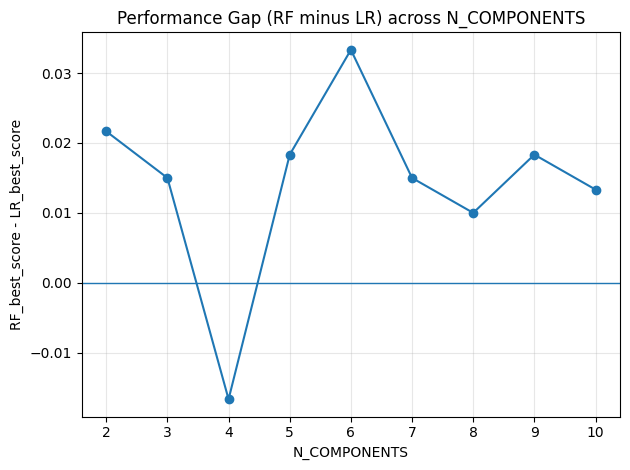

In [25]:
#RF-LR
plt.plot(res_df["N_COMPONENTS"], res_df["RF_best_score"] - res_df["LR_best_score"], marker="o")
plt.axhline(0, linewidth=1)
plt.xlabel("N_COMPONENTS")
plt.ylabel("RF_best_score - LR_best_score")
plt.title("Performance Gap (RF minus LR) across N_COMPONENTS")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
def plot_mds_2d(D, y, N_COMPONENTS, title):
    mds = MDS(
        n_components=2,          
        dissimilarity="precomputed",
        random_state=42,
        n_init=4,
        max_iter=300
    )
    X_2d = mds.fit_transform(D)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=y,
        cmap="coolwarm",
        alpha=0.8
    )
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.title(title)
    plt.colorbar(scatter, label="Class label")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

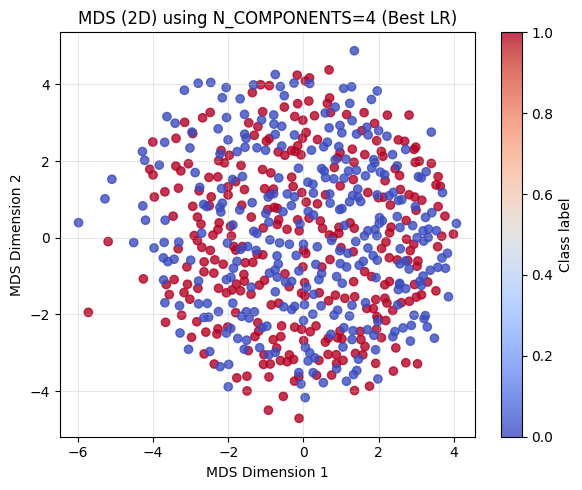

In [27]:
best_N_lr = best_lr["N_COMPONENTS"]
best_N_rf = best_rf["N_COMPONENTS"]

plot_mds_2d(
    D,
    y,
    best_N_lr,
    title=f"MDS (2D) using N_COMPONENTS={best_N_lr} (Best LR)"
)


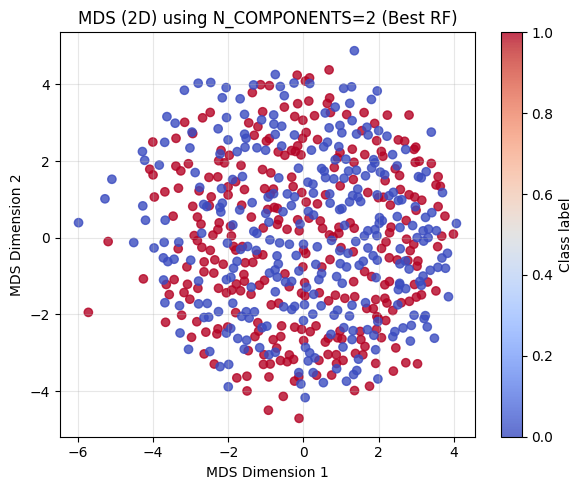

In [28]:
plot_mds_2d(
    D,
    y,
    best_N_rf,
    title=f"MDS (2D) using N_COMPONENTS={best_N_rf} (Best RF)"
)

3.  Euclidean distance with fisher-z
Here we did the fisher-z to all data and then calculate Euclidean distance matrix as follows

In [29]:
eps = 1e-6
X_clipped = np.clip(X, -1 + eps, 1 - eps)

# Fisher z-transform: z = 0.5 * ln((1+r)/(1-r))
X_z = 0.5 * np.log((1 + X_clipped) / (1 - X_clipped))
print("Fisher-z transformed X_z shape:", X_z.shape)

metric = "euclidean"   

fishz_dist_mat = squareform(pdist(X_z, metric=metric))
print("Distance matrix shape:", fishz_dist_mat.shape)

fishz_dist_df = pd.DataFrame(
    fishz_dist_mat,
    index=order_info["participant_id"],
    columns=order_info["participant_id"]
)

out_name = f"dist_matrix_100_fisherz_{metric}.csv"
fishz_dist_df.to_csv(out_name)
print(f"Distance matrix saved to {out_name}")

Fisher-z transformed X_z shape: (600, 10)
Distance matrix shape: (600, 600)
Distance matrix saved to dist_matrix_100_fisherz_euclidean.csv


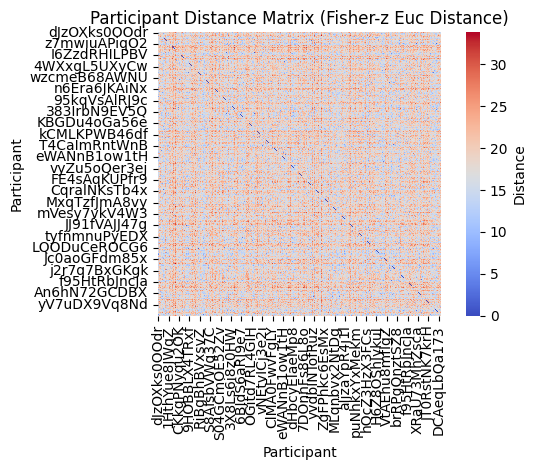

In [62]:
sns.heatmap(
    fishz_dist_df,
    cmap="coolwarm",        # or "coolwarm", "magma"
    square=True,
    cbar_kws={"label": "Distance"}
)
plt.title("Participant Distance Matrix (Fisher-z Euc Distance)")
plt.xlabel("Participant")
plt.ylabel("Participant")
plt.tight_layout()
plt.show()

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

N_COMPONENTS_GRID = [2, 3, 4, 5, 6, 7, 8, 9, 10]
C_GRID = [0.01, 0.1, 1, 5, 10, 50, 100]
RF_GRID = {
    "n_estimators": [100, 200, 300, 500,1000],
    "max_depth": [None, 1, 2, 3, 5, 10, 20]
}

best_lr = {"score": -np.inf}
best_rf = {"score": -np.inf}

In [32]:
results = []

order_info_sorted = order_info.sort_values("ADHD_Outcome")  
pid_order = order_info_sorted["participant_id"].tolist()
dist_df = fishz_dist_df.loc[pid_order, pid_order]
D = dist_df.values 

for N_COMPONENTS in N_COMPONENTS_GRID:
    mds = MDS(
        n_components=N_COMPONENTS,
        dissimilarity="precomputed",
        random_state=42,
        n_init=4,
        max_iter=300
    )
    X_embed = mds.fit_transform(D)
    X = StandardScaler().fit_transform(X_embed)

    gs_lr = GridSearchCV(
        LogisticRegression(penalty="l2", solver="lbfgs", max_iter=1000),
        param_grid={"C": C_GRID},
        scoring="accuracy",
        cv=kf,
        n_jobs=-1,
        refit=True
    )
    gs_lr.fit(X, y)

    gs_rf = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=RF_GRID,
        scoring="accuracy",
        cv=kf,
        n_jobs=-1,
        refit=True
    )
    gs_rf.fit(X, y)

    results.append({
        "N_COMPONENTS": N_COMPONENTS,
        "LR_best_score": gs_lr.best_score_,
        "LR_best_C": gs_lr.best_params_["C"],
        "RF_best_score": gs_rf.best_score_,
        "RF_best_depth": gs_rf.best_params_["max_depth"],
        "RF_best_trees": gs_rf.best_params_["n_estimators"],
    })

    if gs_lr.best_score_ > best_lr["score"]:
        best_lr = {"score": gs_lr.best_score_, "N_COMPONENTS": N_COMPONENTS, "params": gs_lr.best_params_}
    if gs_rf.best_score_ > best_rf["score"]:
        best_rf = {"score": gs_rf.best_score_, "N_COMPONENTS": N_COMPONENTS, "params": gs_rf.best_params_}

    print(f"\nN_COMPONENTS={N_COMPONENTS}")
    print("  LR best:", gs_lr.best_score_, gs_lr.best_params_)
    print("  RF best:", gs_rf.best_score_, gs_rf.best_params_)

print("\nBEST OVERALL")
print("Best LR :", best_lr)
print("Best RF :", best_rf)


N_COMPONENTS=2
  LR best: 0.5016666666666667 {'C': 0.01}
  RF best: 0.5366666666666666 {'max_depth': None, 'n_estimators': 1000}

N_COMPONENTS=3
  LR best: 0.53 {'C': 1}
  RF best: 0.5583333333333333 {'max_depth': None, 'n_estimators': 100}

N_COMPONENTS=4
  LR best: 0.5433333333333333 {'C': 0.1}
  RF best: 0.5416666666666666 {'max_depth': 3, 'n_estimators': 100}

N_COMPONENTS=5
  LR best: 0.52 {'C': 0.1}
  RF best: 0.5033333333333333 {'max_depth': 10, 'n_estimators': 100}

N_COMPONENTS=6
  LR best: 0.5116666666666667 {'C': 0.1}
  RF best: 0.525 {'max_depth': 1, 'n_estimators': 500}

N_COMPONENTS=7
  LR best: 0.5216666666666667 {'C': 1}
  RF best: 0.51 {'max_depth': 3, 'n_estimators': 500}

N_COMPONENTS=8
  LR best: 0.5216666666666667 {'C': 0.1}
  RF best: 0.5466666666666666 {'max_depth': 5, 'n_estimators': 1000}

N_COMPONENTS=9
  LR best: 0.5116666666666666 {'C': 0.1}
  RF best: 0.5266666666666666 {'max_depth': 20, 'n_estimators': 100}

N_COMPONENTS=10
  LR best: 0.5216666666666667 {

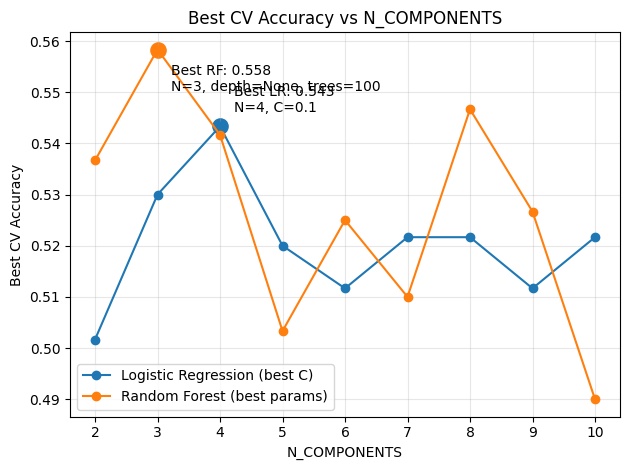

In [33]:
res_df = pd.DataFrame(results).sort_values("N_COMPONENTS")

plt.plot(res_df["N_COMPONENTS"], res_df["LR_best_score"], marker="o", label="Logistic Regression (best C)")
plt.plot(res_df["N_COMPONENTS"], res_df["RF_best_score"], marker="o", label="Random Forest (best params)")

plt.scatter([best_lr["N_COMPONENTS"]], [best_lr["score"]], s=120)
plt.scatter([best_rf["N_COMPONENTS"]], [best_rf["score"]], s=120)

plt.annotate(f"Best LR: {best_lr['score']:.3f}\nN={best_lr['N_COMPONENTS']}, C={best_lr['params']['C']}",
             (best_lr["N_COMPONENTS"], best_lr["score"]), textcoords="offset points", xytext=(10, 10))
plt.annotate(f"Best RF: {best_rf['score']:.3f}\nN={best_rf['N_COMPONENTS']}, depth={best_rf['params']['max_depth']}, trees={best_rf['params']['n_estimators']}",
             (best_rf["N_COMPONENTS"], best_rf["score"]), textcoords="offset points", xytext=(10, -30))

plt.xlabel("N_COMPONENTS")
plt.ylabel("Best CV Accuracy")
plt.title("Best CV Accuracy vs N_COMPONENTS")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

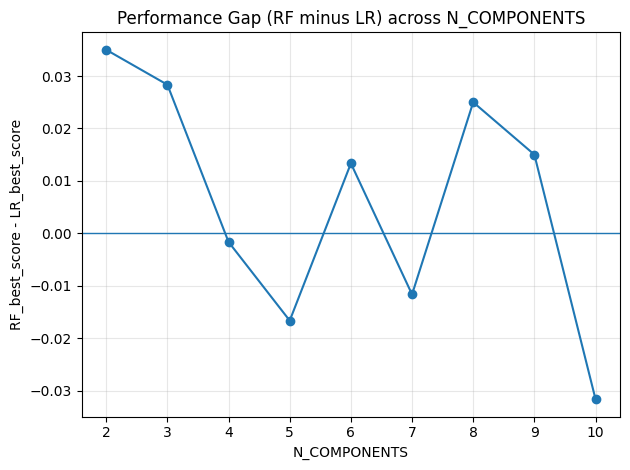

In [34]:
#RF-LR
plt.plot(res_df["N_COMPONENTS"], res_df["RF_best_score"] - res_df["LR_best_score"], marker="o")
plt.axhline(0, linewidth=1)
plt.xlabel("N_COMPONENTS")
plt.ylabel("RF_best_score - LR_best_score")
plt.title("Performance Gap (RF minus LR) across N_COMPONENTS")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
def plot_mds_2d(D, y, N_COMPONENTS, title):
    mds = MDS(
        n_components=2,          
        dissimilarity="precomputed",
        random_state=42,
        n_init=4,
        max_iter=300
    )
    X_2d = mds.fit_transform(D)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=y,
        cmap="coolwarm",
        alpha=0.8
    )
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.title(title)
    plt.colorbar(scatter, label="Class label")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

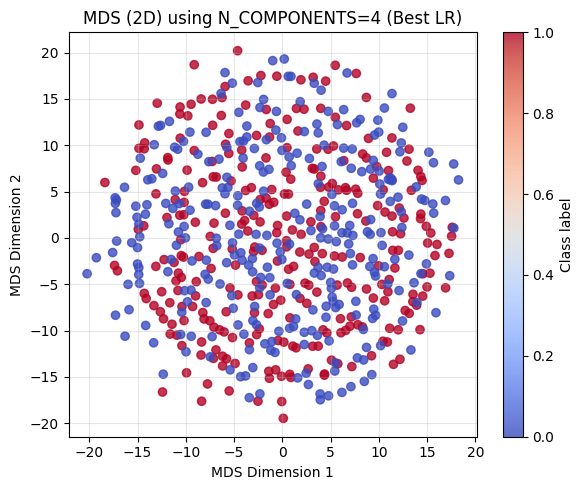

In [36]:
best_N_lr = best_lr["N_COMPONENTS"]
best_N_rf = best_rf["N_COMPONENTS"]

plot_mds_2d(
    D,
    y,
    best_N_lr,
    title=f"MDS (2D) using N_COMPONENTS={best_N_lr} (Best LR)"
)


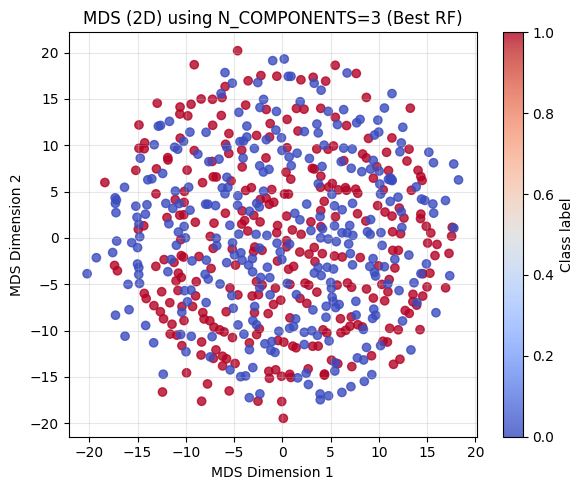

In [37]:
plot_mds_2d(
    D,
    y,
    best_N_rf,
    title=f"MDS (2D) using N_COMPONENTS={best_N_rf} (Best RF)"
)

4. cosine distance
- Cosine distance measures how similar two feature vectors are based on their direction rather than their absolute values. Smaller distances indicate more similar patterns across features. This makes cosine distance useful when the overall scale of the data varies across participants.

In [38]:
metric = "cosine"   

cos_dist_mat = squareform(pdist(X, metric=metric))
print("Distance matrix shape:", cos_dist_mat.shape)

cos_dist_df = pd.DataFrame(
    cos_dist_mat,
    index=order_info["participant_id"],
    columns=order_info["participant_id"]
)

out_name = f"dist_matrix_100_cosine.csv"
cos_dist_df.to_csv(out_name)
print(f"Distance matrix saved to {out_name}")

Distance matrix shape: (600, 600)
Distance matrix saved to dist_matrix_100_cosine.csv


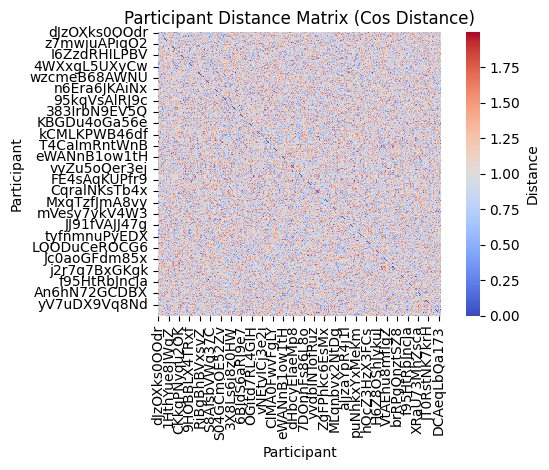

In [39]:
sns.heatmap(
    cos_dist_df,
    cmap="coolwarm",        # or "coolwarm", "magma"
    square=True,
    cbar_kws={"label": "Distance"}
)
plt.title("Participant Distance Matrix (Cos Distance)")
plt.xlabel("Participant")
plt.ylabel("Participant")
plt.tight_layout()
plt.show()

In [40]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

N_COMPONENTS_GRID = [2, 3, 4, 5, 6, 7, 8, 9, 10]
C_GRID = [0.01, 0.1, 1, 5, 10, 50, 100]
RF_GRID = {
    "n_estimators": [100, 200, 300, 500,1000],
    "max_depth": [None, 1, 2, 3, 5, 10, 20]
}

best_lr = {"score": -np.inf}
best_rf = {"score": -np.inf}

In [41]:
results = []

order_info_sorted = order_info.sort_values("ADHD_Outcome")  
pid_order = order_info_sorted["participant_id"].tolist()
dist_df = cos_dist_df.loc[pid_order, pid_order]
D = dist_df.values 

for N_COMPONENTS in N_COMPONENTS_GRID:
    mds = MDS(
        n_components=N_COMPONENTS,
        dissimilarity="precomputed",
        random_state=42,
        n_init=4,
        max_iter=300
    )
    X_embed = mds.fit_transform(D)
    X = StandardScaler().fit_transform(X_embed)

    gs_lr = GridSearchCV(
        LogisticRegression(penalty="l2", solver="lbfgs", max_iter=1000),
        param_grid={"C": C_GRID},
        scoring="accuracy",
        cv=kf,
        n_jobs=-1,
        refit=True
    )
    gs_lr.fit(X, y)

    gs_rf = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=RF_GRID,
        scoring="accuracy",
        cv=kf,
        n_jobs=-1,
        refit=True
    )
    gs_rf.fit(X, y)

    results.append({
        "N_COMPONENTS": N_COMPONENTS,
        "LR_best_score": gs_lr.best_score_,
        "LR_best_C": gs_lr.best_params_["C"],
        "RF_best_score": gs_rf.best_score_,
        "RF_best_depth": gs_rf.best_params_["max_depth"],
        "RF_best_trees": gs_rf.best_params_["n_estimators"],
    })

    if gs_lr.best_score_ > best_lr["score"]:
        best_lr = {"score": gs_lr.best_score_, "N_COMPONENTS": N_COMPONENTS, "params": gs_lr.best_params_}
    if gs_rf.best_score_ > best_rf["score"]:
        best_rf = {"score": gs_rf.best_score_, "N_COMPONENTS": N_COMPONENTS, "params": gs_rf.best_params_}

    print(f"\nN_COMPONENTS={N_COMPONENTS}")
    print("  LR best:", gs_lr.best_score_, gs_lr.best_params_)
    print("  RF best:", gs_rf.best_score_, gs_rf.best_params_)

print("\nBEST OVERALL")
print("Best LR :", best_lr)
print("Best RF :", best_rf)


N_COMPONENTS=2
  LR best: 0.5316666666666666 {'C': 1}
  RF best: 0.505 {'max_depth': None, 'n_estimators': 500}

N_COMPONENTS=3
  LR best: 0.5116666666666666 {'C': 0.1}
  RF best: 0.5033333333333333 {'max_depth': 5, 'n_estimators': 100}

N_COMPONENTS=4
  LR best: 0.49333333333333335 {'C': 0.1}
  RF best: 0.5033333333333333 {'max_depth': 1, 'n_estimators': 100}

N_COMPONENTS=5
  LR best: 0.5116666666666667 {'C': 0.1}
  RF best: 0.505 {'max_depth': None, 'n_estimators': 100}

N_COMPONENTS=6
  LR best: 0.495 {'C': 0.01}
  RF best: 0.52 {'max_depth': 3, 'n_estimators': 200}

N_COMPONENTS=7
  LR best: 0.4833333333333334 {'C': 0.1}
  RF best: 0.5166666666666667 {'max_depth': 10, 'n_estimators': 200}

N_COMPONENTS=8
  LR best: 0.505 {'C': 1}
  RF best: 0.52 {'max_depth': 5, 'n_estimators': 1000}

N_COMPONENTS=9
  LR best: 0.49333333333333335 {'C': 1}
  RF best: 0.5 {'max_depth': 2, 'n_estimators': 500}

N_COMPONENTS=10
  LR best: 0.495 {'C': 0.1}
  RF best: 0.54 {'max_depth': 1, 'n_estimator

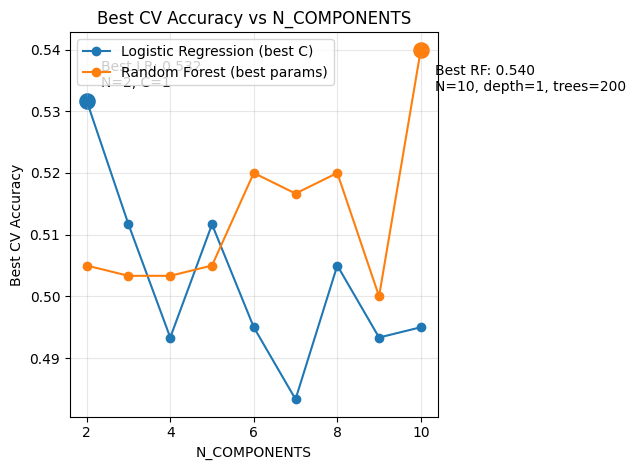

In [42]:
res_df = pd.DataFrame(results).sort_values("N_COMPONENTS")

plt.plot(res_df["N_COMPONENTS"], res_df["LR_best_score"], marker="o", label="Logistic Regression (best C)")
plt.plot(res_df["N_COMPONENTS"], res_df["RF_best_score"], marker="o", label="Random Forest (best params)")

plt.scatter([best_lr["N_COMPONENTS"]], [best_lr["score"]], s=120)
plt.scatter([best_rf["N_COMPONENTS"]], [best_rf["score"]], s=120)

plt.annotate(f"Best LR: {best_lr['score']:.3f}\nN={best_lr['N_COMPONENTS']}, C={best_lr['params']['C']}",
             (best_lr["N_COMPONENTS"], best_lr["score"]), textcoords="offset points", xytext=(10, 10))
plt.annotate(f"Best RF: {best_rf['score']:.3f}\nN={best_rf['N_COMPONENTS']}, depth={best_rf['params']['max_depth']}, trees={best_rf['params']['n_estimators']}",
             (best_rf["N_COMPONENTS"], best_rf["score"]), textcoords="offset points", xytext=(10, -30))

plt.xlabel("N_COMPONENTS")
plt.ylabel("Best CV Accuracy")
plt.title("Best CV Accuracy vs N_COMPONENTS")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

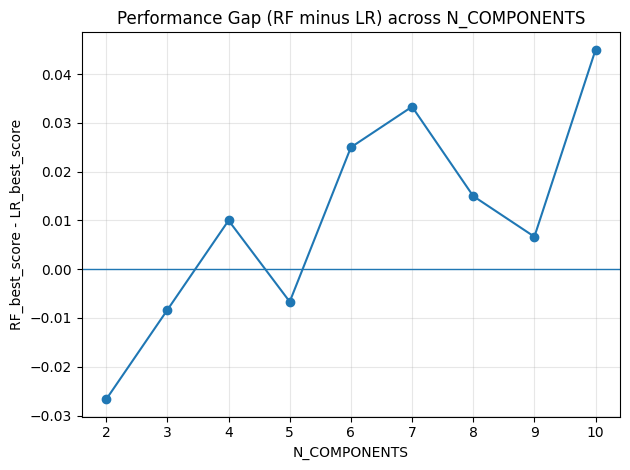

In [43]:
#RF-LR
plt.plot(res_df["N_COMPONENTS"], res_df["RF_best_score"] - res_df["LR_best_score"], marker="o")
plt.axhline(0, linewidth=1)
plt.xlabel("N_COMPONENTS")
plt.ylabel("RF_best_score - LR_best_score")
plt.title("Performance Gap (RF minus LR) across N_COMPONENTS")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

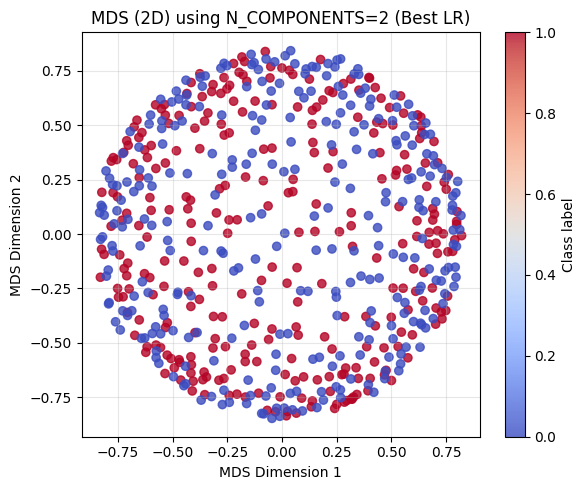

In [44]:
best_N_lr = best_lr["N_COMPONENTS"]
best_N_rf = best_rf["N_COMPONENTS"]

plot_mds_2d(
    D,
    y,
    best_N_lr,
    title=f"MDS (2D) using N_COMPONENTS={best_N_lr} (Best LR)"
)


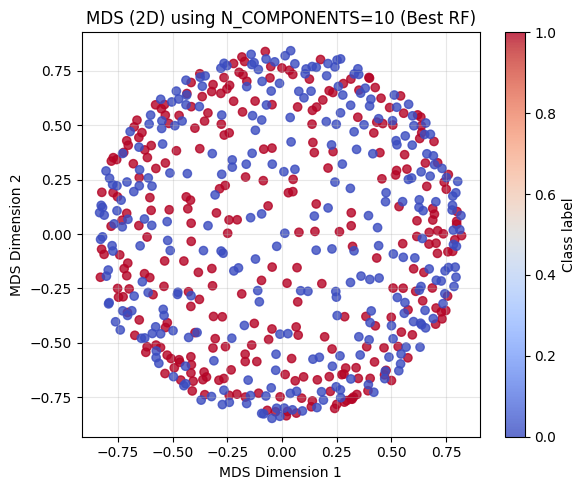

In [45]:
plot_mds_2d(
    D,
    y,
    best_N_rf,
    title=f"MDS (2D) using N_COMPONENTS={best_N_rf} (Best RF)"
)

5. cosine-based distance ( from professor)

In [46]:
def corr_dist(A,B):
    from scipy.linalg import norm
    D = np.transpose(np.conj(A))@B
    dist = np.real(np.log(1.0/(np.trace(D)/(norm(A)*norm(B)))))
    return dist

N = X.shape[0]
newdist_mat = np.zeros((N, N), dtype=float)

for i in range(N):
    Ai = X[i].reshape(1, -1)   
    for j in range(i, N):
        Bj = X[j].reshape(1, -1)
        d = corr_dist(Ai, Bj)
        newdist_mat[i, j] = d
        newdist_mat[j, i] = d  

newdist_df = pd.DataFrame(newdist_mat,
                          index=order_info["participant_id"],
                          columns=order_info["participant_id"])
newdist_df.to_csv("dist_matrix_100_newdist.csv")

/var/folders/94/zw2h7h514wx428yyqkpflqsr0000gn/T/ipykernel_18706/780889213.py:4: RuntimeWarning: invalid value encountered in log
  dist = np.real(np.log(1.0/(np.trace(D)/(norm(A)*norm(B)))))


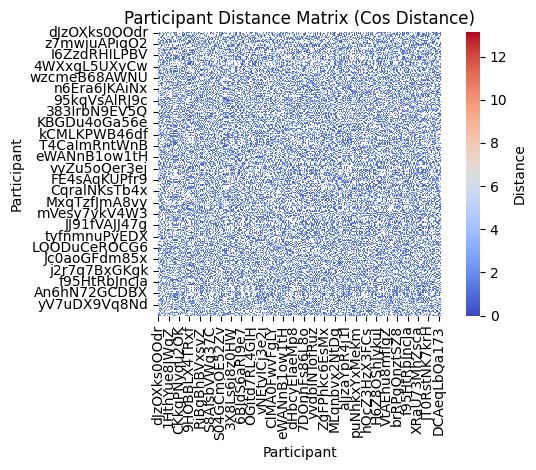

In [ ]:
sns.heatmap(
    newdist_df,
    cmap="coolwarm",       
    square=True,
    cbar_kws={"label": "Distance"}
)
plt.title("Participant Distance Matrix (Cos-based Distance)")
plt.xlabel("Participant")
plt.ylabel("Participant")
plt.tight_layout()
plt.show()

There are too many NAN inside this matrix, making the following analysis uncorrected. So we choose to not to contimue this method and focus on other methods.

Conclusion:



Distance-based representations can capture some meaningful structure in ADHD functional connectivity data. However, the predictive signal is weak. Model choice has a small effect, while distance choice has a clearer impact on performance. These methods are most useful for exploratory analysis rather than strong prediction.
